## Задание

### Вариант 1

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

### Задача 1 -- 3

Импортируем библиотеки

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import os

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

Прочитаем csv-файл

In [3]:
cons = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
cons.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Сделаем ресемплинг

In [4]:
w_cons=cons.resample('W').mean()
w_cons.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


Разделим данные на тренировочные и тестовые

In [5]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

C:\Program Files\Python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


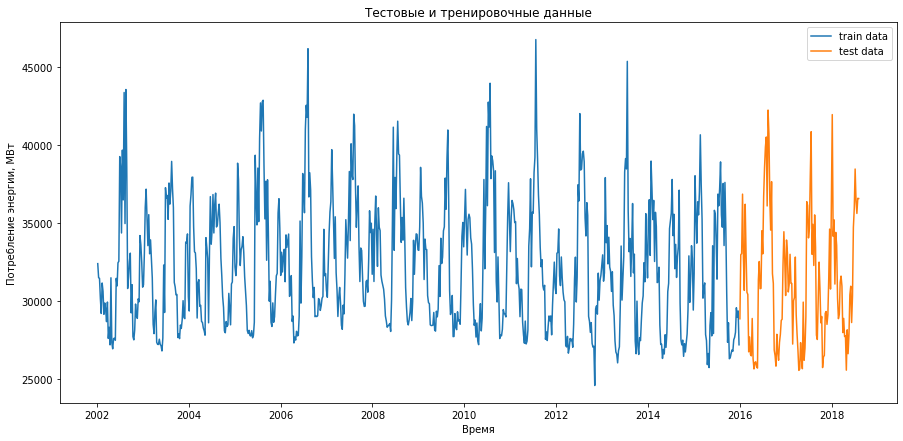

In [6]:
train, test = split_data( w_cons, '01-01-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

Разобьем датафрейм на признаки и на целевое значение

In [7]:
X_train = train.loc[:, train.columns != 'PJME_MW']
Y_train = train['PJME_MW']
X_test = test.loc[:, train.columns != 'PJME_MW']
Y_test = test['PJME_MW']

Определим оптимальые параметры для расчета модели

In [8]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=40):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,10,14,5], 
              "n_estimators":[100,200,300,400,500, 1000, 1200,1500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, Y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.652 (std: 0.047)
Parameters: {'n_estimators': 100, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.642 (std: 0.061)
Parameters: {'n_estimators': 200, 'max_depth': 2}

Model with rank: 3
Mean validation score: 0.628 (std: 0.043)
Parameters: {'n_estimators': 200, 'max_depth': 3}

Model with rank: 4
Mean validation score: 0.590 (std: 0.066)
Parameters: {'n_estimators': 100, 'max_depth': 5}

Model with rank: 5
Mean validation score: 0.563 (std: 0.070)
Parameters: {'n_estimators': 300, 'max_depth': 5}

Model with rank: 6
Mean validation score: 0.540 (std: 0.076)
Parameters: {'n_estimators': 1200, 'max_depth': 5}

Model with rank: 7
Mean validation score: 0.466 (std: 0.092)
Parameters: {'n_estimators': 200, 'max_depth': 10}

Model with rank: 8
Mean validation score: 0.462 (std: 0.097)
Parameters: {'n_estimators': 100, 'max_depth': 10}

Model with rank: 9
Mean validation score: 0.394 (std: 0.088)
Parameters: {'n_estimators': 300, 'max_d

Наиболее оптимальный параметр это - {'n_estimators': 200}, имеющий Mean validation score: 0.628 (std: 0.043)

Определим модель и произведем расчет для h = 1

In [30]:
model_cons_1 = GradientBoostingRegressor(max_depth=1, random_state=0, n_estimators=200)

In [31]:
model_cons_1.fit( X_train, Y_train ) 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=1,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [32]:
Y_test_pred_g_1 = model_cons_1.predict(X_test)

Изобразим полученный результат

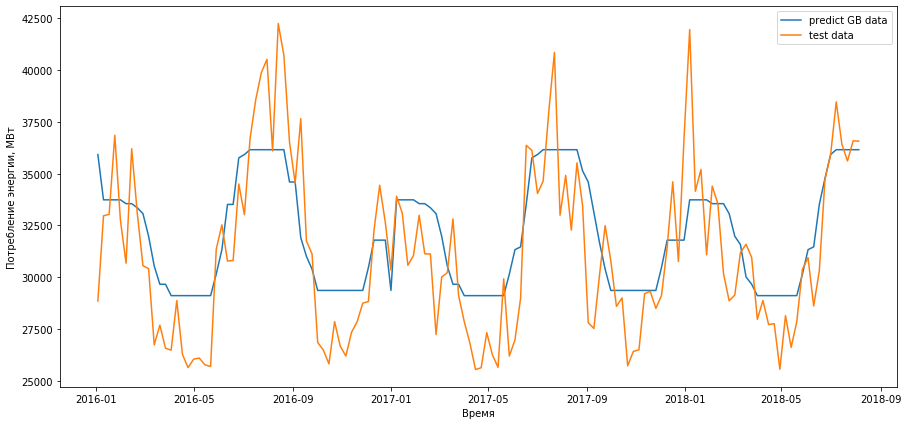

In [34]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(Y_test.index,Y_test_pred_g_1, label='predict GB data' )
plt.plot(Y_test.index,Y_test, label='test data')

plt.legend()
plt.show()

Подсчитаем метрики

In [13]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [38]:
er_g_1 = mean_absolute_percentage_error(Y_test,Y_test_pred_g_1)

print('ошибка градиентного бустинга MAPE :  ', er_g_1,'%')

ошибка градиентного бустинга MAPE :   7.050350859793873 %


In [39]:
er_s_1 = mean_squared_error(Y_test, Y_test_pred_g_1) 
er_a_1 = mean_absolute_error(Y_test, Y_test_pred_g_1) 
er_r2_1 = r2_score(Y_test, Y_test_pred_g_1)

print('ошибка mse :  ', er_s_1,'\nошибка mae  :  ', er_a_1,'\nоценка R2 :  ', er_r2_1)

ошибка mse :   7173287.2722230675 
ошибка mae  :   2139.871467549366 
оценка R2 :   0.5653511111027257


Построим кривую корреляции и предсказаний

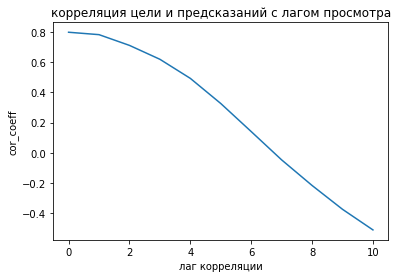

In [40]:
lag=10
p_cor=[np.corrcoef( Y_test, Y_test_pred_g_1)[1,0]]
for i in range(lag):
    c=np.corrcoef( Y_test[:-(i+1)], Y_test_pred_g_1[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция цели и предсказаний с лагом просмотра')
plt.show()

Кривая имеют форму, похожую на идеальную

Повторим расчет для h = 4

In [42]:
model_cons_4 = GradientBoostingRegressor(max_depth=4, random_state=0, n_estimators=200)

In [43]:
model_cons_4.fit( X_train, Y_train ) 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [44]:
Y_test_pred_g_4 = model_cons_4.predict(X_test)

Изобразим полученный результат

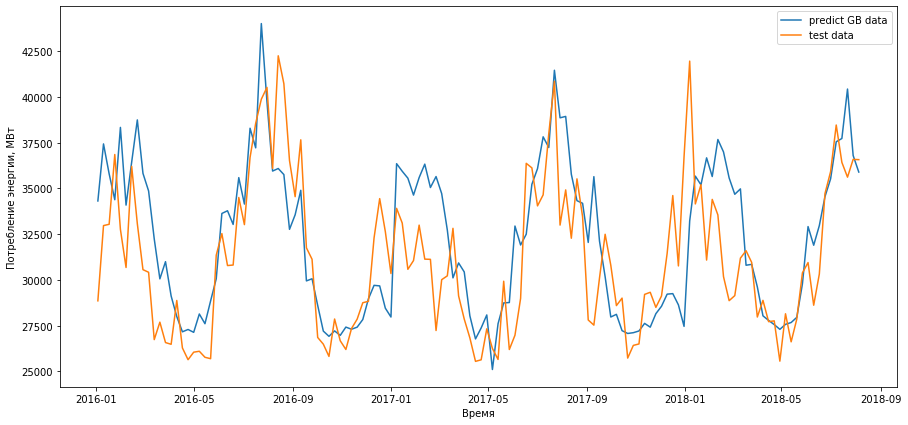

In [45]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(Y_test.index,Y_test_pred_g_4, label='predict GB data' )
plt.plot(Y_test.index,Y_test, label='test data')

plt.legend()
plt.show()

Подсчитаем метрики

In [46]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [48]:
er_g_4 = mean_absolute_percentage_error(Y_test,Y_test_pred_g_4)

print('ошибка градиентного бустинга MAPE :  ', er_g_4,'%')

ошибка градиентного бустинга MAPE :   7.981857253592158 %


In [50]:
er_s_4 = mean_squared_error(Y_test, Y_test_pred_g_4) 
er_a_4 = mean_absolute_error(Y_test, Y_test_pred_g_4) 
er_r2_4 = r2_score(Y_test, Y_test_pred_g_4)

print('ошибка mse :  ', er_s_4,'\nошибка mae  :  ', er_a_4,'\nоценка R2 :  ', er_r2_4)

ошибка mse :   10280984.375359222 
ошибка mae  :   2487.0588268410074 
оценка R2 :   0.37704733326046524


Построим кривую корреляции и предсказаний

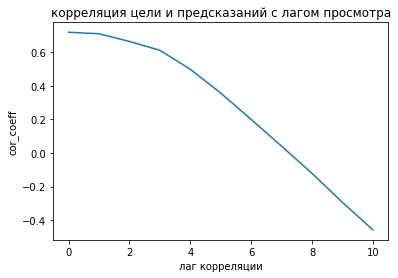

In [51]:
lag=10
p_cor=[np.corrcoef( Y_test, Y_test_pred_g_4)[1,0]]
for i in range(lag):
    c=np.corrcoef( Y_test[:-(i+1)], Y_test_pred_g_4[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция цели и предсказаний с лагом просмотра')
plt.show()

Кривая имеют форму, похожую на идеальную

### Задача 4

Для выполнения данных задач возьмем срез последних 100 значений

In [80]:
p = 10
X_test_100 = X_test['2016-09-11':'2018-08-05'].copy()
y_test_100 = Y_test['2016-09-11':'2018-08-05'].copy()

In [81]:
X_test_100 = X_test_100.reset_index(drop=True)
y_test_100 = y_test_100.reset_index(drop=True)

Произведем прогноз для 4-ем точек

In [83]:
y_predict_4 = model_cons.predict(X_test_100[0:3])

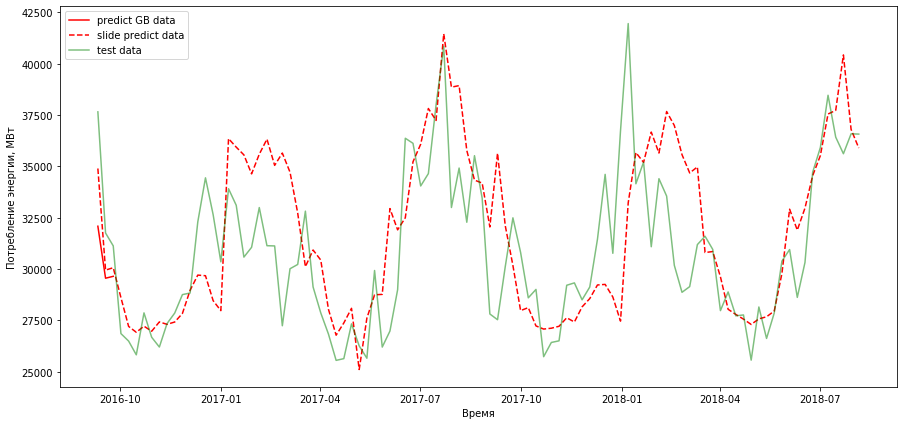

In [104]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(Y_test.index[36:39],y_predict_4, 'r',label='predict GB data' )
plt.plot(Y_test.index[36:136],Y_test_pred_g_4[36:136], '--r',label='slide predict data')
plt.plot(Y_test.index[36:136],Y_test[36:136], 'g',label='test data', alpha=0.5)
#plt.plot(test.index[p],y_test[p-1], 'og', alpha=1)
plt.legend()
plt.show() 

Подсчитаем метрики

In [107]:
er_g_4 = mean_absolute_percentage_error(Y_test[0:3],y_predict_4)

print('ошибка градиентного бустинга MAPE :  ', er_g_4,'%')

ошибка градиентного бустинга MAPE :   10.604913532534004 %


In [108]:
er_s_4 = mean_squared_error(Y_test[0:3],y_predict_4)
er_a_4 = mean_absolute_error(Y_test[0:3],y_predict_4)
er_r2_4 = r2_score(Y_test[0:3],y_predict_4)

print('ошибка mse :  ', er_s_4,'\nошибка mae  :  ', er_a_4,'\nоценка R2 :  ', er_r2_4)

ошибка mse :   11197963.929963095 
ошибка mae  :   3345.255677763489 
оценка R2 :   -1.9319119875648063


Построим кривую корреляции и предсказаний

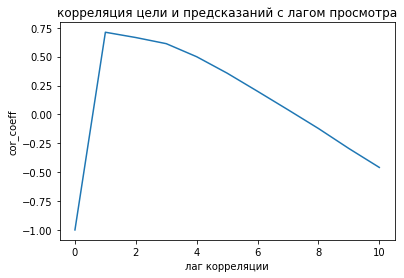

In [109]:
lag=10
p_cor=[np.corrcoef(Y_test[0:3],y_predict_4)[1,0]]
for i in range(lag):
    c=np.corrcoef( Y_test[:-(i+1)], Y_test_pred_g_4[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция цели и предсказаний с лагом просмотра')
plt.show()

Метрики хуже, чем у обычного прогноза

### Задача 5

Построим прогноз для 1-10, 11-20, 21-30...91-100-ых значений

Результаты прогноза для 1-10:

In [110]:
y_predict_10 = model_cons.predict(X_test_100[0:10])

In [123]:
er_g_10 = mean_absolute_percentage_error(Y_test[36:46],y_predict_10)

print('ошибка градиентного бустинга MAPE :  ', er_g_10,'%')

ошибка градиентного бустинга MAPE :   5.076133346069237 %


In [124]:
er_s_10 = mean_squared_error(Y_test[36:46],y_predict_10)
er_a_10 = mean_absolute_error(Y_test[36:46],y_predict_10)
er_r2_10 = r2_score(Y_test[36:46],y_predict_10)

print('ошибка mse :  ', er_s_10,'\nошибка mae  :  ', er_a_10,'\nоценка R2 :  ', er_r2_10)

ошибка mse :   4624012.791313647 
ошибка mae  :   1571.1699297768196 
оценка R2 :   0.6294254712930704


Результаты прогноза для 11-20:

In [111]:
y_predict_20 = model_cons.predict(X_test_100[11:20])

In [132]:
er_g_20 = mean_absolute_percentage_error(Y_test[46:55],y_predict_20)

print('ошибка градиентного бустинга MAPE :  ', er_g_20,'%')

ошибка градиентного бустинга MAPE :   7.532130377800447 %


In [131]:
er_s_20 = mean_squared_error(Y_test[46:55],y_predict_20)
er_a_20 = mean_absolute_error(Y_test[46:55],y_predict_20)
er_r2_20 = r2_score(Y_test[46:55],y_predict_20)

print('ошибка mse :  ', er_s_20,'\nошибка mae  :  ', er_a_20,'\nоценка R2 :  ', er_r2_20)

ошибка mse :   9782682.26337173 
ошибка mae  :   2402.6324675199157 
оценка R2 :   -0.8325845584759402


Результаты прогноза для 21-30:

In [112]:
y_predict_30 = model_cons.predict(X_test_100[21:30])

In [133]:
er_g_30 = mean_absolute_percentage_error(Y_test[56:65],y_predict_30)

print('ошибка градиентного бустинга MAPE :  ', er_g_30,'%')

ошибка градиентного бустинга MAPE :   10.034919602431188 %


In [134]:
er_s_30 = mean_squared_error(Y_test[56:65],y_predict_30)
er_a_30 = mean_absolute_error(Y_test[56:65],y_predict_30)
er_r2_30 = r2_score(Y_test[56:65],y_predict_30)

print('ошибка mse :  ', er_s_30,'\nошибка mae  :  ', er_a_30,'\nоценка R2 :  ', er_r2_30)

ошибка mse :   12749841.146855192 
ошибка mae  :   3026.1734559967776 
оценка R2 :   -3.521546393555166


Результаты прогноза для 31-40:

In [113]:
y_predict_40 = model_cons.predict(X_test_100[31:40])

In [136]:
er_g_40 = mean_absolute_percentage_error(Y_test[66:75],y_predict_40)

print('ошибка градиентного бустинга MAPE :  ', er_g_40,'%')

ошибка градиентного бустинга MAPE :   8.59000727035394 %


In [138]:
er_s_40 = mean_squared_error(Y_test[66:75],y_predict_40)
er_a_40 = mean_absolute_error(Y_test[66:75],y_predict_40)
er_r2_40 = r2_score(Y_test[66:75],y_predict_40)

print('ошибка mse :  ', er_s_40,'\nошибка mae  :  ', er_a_40,'\nоценка R2 :  ', er_r2_40)

ошибка mse :   8414840.627449384 
ошибка mae  :   2255.5749476627916 
оценка R2 :   -4.081150552865446


Результаты прогноза для 41-50:

In [114]:
y_predict_50 = model_cons.predict(X_test_100[41:50])

In [141]:
er_g_50 = mean_absolute_percentage_error(Y_test[76:85],y_predict_50)

print('ошибка градиентного бустинга MAPE :  ', er_g_50,'%')

ошибка градиентного бустинга MAPE :   7.2224059124460505 %


In [142]:
er_s_50 = mean_squared_error(Y_test[76:85],y_predict_50)
er_a_50 = mean_absolute_error(Y_test[76:85],y_predict_50)
er_r2_50 = r2_score(Y_test[76:85],y_predict_50)

print('ошибка mse :  ', er_s_50,'\nошибка mae  :  ', er_a_50,'\nоценка R2 :  ', er_r2_50)

ошибка mse :   9359551.698300824 
ошибка mae  :   2490.326322643143 
оценка R2 :   -0.510056957822397


Результаты прогноза для 61-70:

In [115]:
y_predict_60 = model_cons.predict(X_test_100[51:60])

In [147]:
er_g_60 = mean_absolute_percentage_error(Y_test[86:95],y_predict_60)

print('ошибка градиентного бустинга MAPE :  ', er_g_60,'%')

ошибка градиентного бустинга MAPE :   7.531333534555445 %


In [148]:
er_s_60 = mean_squared_error(Y_test[86:95],y_predict_60)
er_a_60 = mean_absolute_error(Y_test[86:95],y_predict_60)
er_r2_60 = r2_score(Y_test[86:95],y_predict_60)

print('ошибка mse :  ', er_s_60,'\nошибка mae  :  ', er_a_60,'\nоценка R2 :  ', er_r2_60)

ошибка mse :   7351228.435436098 
ошибка mae  :   2204.5975133071684 
оценка R2 :   -0.35991124842699307


Результаты прогноза для 71-80:

In [116]:
y_predict_70 = model_cons.predict(X_test_100[61:70])

In [150]:
er_g_70 = mean_absolute_percentage_error(Y_test[96:105],y_predict_70)

print('ошибка градиентного бустинга MAPE :  ', er_g_70,'%')

ошибка градиентного бустинга MAPE :   7.084961399397721 %


In [151]:
er_s_70 = mean_squared_error(Y_test[96:105],y_predict_70)
er_a_70 = mean_absolute_error(Y_test[96:105],y_predict_70)
er_r2_70 = r2_score(Y_test[96:105],y_predict_70)

print('ошибка mse :  ', er_s_70,'\nошибка mae  :  ', er_a_70,'\nоценка R2 :  ', er_r2_70)

ошибка mse :   7985623.2496278435 
ошибка mae  :   2276.152318801948 
оценка R2 :   0.11595295584557186


Результаты прогноза для 81-90:

In [117]:
y_predict_80 = model_cons.predict(X_test_100[71:80])

In [153]:
er_g_80 = mean_absolute_percentage_error(Y_test[106:115],y_predict_80)

print('ошибка градиентного бустинга MAPE :  ', er_g_80,'%')

ошибка градиентного бустинга MAPE :   9.8274713476244 %


In [154]:
er_s_80 = mean_squared_error(Y_test[106:115],y_predict_80)
er_a_80 = mean_absolute_error(Y_test[106:115],y_predict_80)
er_r2_80 = r2_score(Y_test[106:115],y_predict_80)

print('ошибка mse :  ', er_s_80,'\nошибка mae  :  ', er_a_80,'\nоценка R2 :  ', er_r2_80)

ошибка mse :   12950285.04332263 
ошибка mae  :   3021.656141712321 
оценка R2 :   -1.5422680604321344


Результаты прогноза для 91-100:

In [155]:
y_predict_90 = model_cons.predict(X_test_100[81:90])

In [157]:
er_g_90 = mean_absolute_percentage_error(Y_test[116:125],y_predict_90)

print('ошибка градиентного бустинга MAPE :  ', er_g_90,'%')

ошибка градиентного бустинга MAPE :   4.078987754290789 %


In [158]:
er_s_90 = mean_squared_error(Y_test[116:125],y_predict_90)
er_a_90 = mean_absolute_error(Y_test[116:125],y_predict_90)
er_r2_90 = r2_score(Y_test[116:125],y_predict_90)

print('ошибка mse :  ', er_s_90,'\nошибка mae  :  ', er_a_90,'\nоценка R2 :  ', er_r2_90)

ошибка mse :   1863808.746801181 
ошибка mae  :   1133.4204895203782 
оценка R2 :   0.04184346058204447


<b>Вывод</b>: при различных выбранных интервалах временного ряда ошибка расчета изменяется стохастически

<b>Общий вывод</b>: в зависимости от выбранного периода имеют место быть различные методы прогноза